# Failed run

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns



from plotting.consts import (
    ATTRS_DICT, FADED_LINE_COLOR, LABEL_COLOR, LIGHT_GREY_TEXT,
    NULL_HEATMAP_COLOUR, TITLE_MAP, PLOT_WIDTH, PLOT_HEIGHT,
    FULL_PAGE_WIDTH
)

from plotting.utils import (
    # divergent_color_scale, get_shape_annotation,
    # get_text_annotation, get_arrow_annotation,
    grey_colorscale_discrete, grey_colorscale_discrete_N,
    invisible_colorbar, my_colorbar_subplot, standard_layout,
    grey_colorscale, my_colorbar, get_big_text_annotation
)

from param_scan.fns.config import config_rand
from param_scan.fns.post_process import PostProcess

from model.strategy_arrays import EqualResFreqBreakdownArray
from model.simulator import RunSingleTactic

from model.config_classes import SingleConfig

# Get data

In [407]:
RUN_TO_CHECK = 183
# RUN_TO_CHECK = 265

In [408]:
par_str = config_rand['par_str']
PP = PostProcess(par_str, '../src/param_scan/outputs')

In [409]:
grid_out = PP.re_run_grid(NDoses=201, run_indices=[RUN_TO_CHECK], plot=False)


Re-running run: 183 

Number of optimal dose combos: 11


In [410]:
FYmax_m2 = int(np.amax(grid_out.FY) - 2)
FYmax_m2

11

In [411]:
yld = grid_out.yield_array[:, :, FYmax_m2]
best_yield = np.amax(yld)
bst_inds = np.where(yld == best_yield)
bst_inds

(array([36], dtype=int64), array([40], dtype=int64))

# best doses

In [412]:
best_i1 = bst_inds[0][0]
best_i2 = bst_inds[1][0]

best_i1, best_i2

(36, 40)

In [413]:
y_best = np.array(grid_out.yield_array[best_i1, best_i2, :])

# smallest RFB

In [414]:
RFB = EqualResFreqBreakdownArray(grid_out).array

In [415]:
small_RFB = abs(RFB) < 0.01

ind_RFB = np.where(small_RFB)

# of these, smallest RR freq in failure year
allowed = grid_out.end_freqs_DA['RR'][ind_RFB[0], ind_RFB[1], FYmax_m2]

min_rr = np.amin(allowed[np.nonzero(allowed)])

which_ind = np.where(allowed == min_rr)[0][0]

rfb_i1, rfb_i2 = ind_RFB[0][which_ind], ind_RFB[1][which_ind]

y_RFB = np.array(grid_out.yield_array[rfb_i1, rfb_i2, :])

In [416]:
min_rr

0.03458598424871151

# Now re-run over 30 years

In [417]:
pars = PP.get_params_for_specific_runs([RUN_TO_CHECK])
pars

,run,omega_1,omega_2,theta_1,theta_2,delta_1,delta_2,RR,RS,SR,...,c_R_min_opt_dist_from_contour,c_E_min_opt_dist_from_contour,maxAlongContour,c_R_maxCont%,c_E_maxCont%,c_E_lowDoseMax%,min_corner,ERFB_diff_from_opt,ESFY_diff_from_opt,ESFYL_diff_from_opt
0,183.0,0.81249,0.69278,2.951951,7.009989,0.004001,0.006771,1.165713e-09,5.311738e-10,1.312246e-10,...,NaN,NaN,0.0,92.307692,92.307692,92.307692,7.0,-1.0,-1.0,-1.0


In [418]:
fung_params = dict(
    omega_1 = pars["omega_1"].iloc[0], 
    omega_2 = pars["omega_2"].iloc[0],
    delta_1 = pars["delta_1"].iloc[0], 
    delta_2 = pars["delta_2"].iloc[0],
    theta_1 = pars["theta_1"].iloc[0], 
    theta_2 = pars["theta_2"].iloc[0],
)

In [419]:
dose_b1 = best_i1/200
dose_b2 = best_i2/200

In [420]:
primary_inoc = dict(
    RR = pars["RR"].iloc[0],
    RS = pars["RS"].iloc[0],
    SR = pars["SR"].iloc[0],
    SS = pars["SS"].iloc[0],
)

sc_best = SingleConfig(35, 
    None, 
    None, 
    dose_b1,
    dose_b1,
    dose_b2,
    dose_b2,
    primary_inoculum=primary_inoc,
    bs_sex_prop=pars['sr_prop'].iloc[0],
)

In [421]:
single_tactic = RunSingleTactic(fung_params)
single_tactic.yield_stopper = 0

In [422]:
best_run = single_tactic.run(sc_best)

In [423]:
dose_rfb1 = rfb_i1/200
dose_rfb2 = rfb_i2/200

sc_rfb = SingleConfig(35, 
    None, 
    None, 
    dose_rfb1,
    dose_rfb1,
    dose_rfb2,
    dose_rfb2,
    primary_inoculum=primary_inoc,
    bs_sex_prop=pars['sr_prop'].iloc[0],
)

In [424]:
rfb_run = single_tactic.run(sc_rfb)

In [425]:
df_use = (
    pd.DataFrame(
        dict(y_b = best_run.yield_vec,
             
             y_rfb = rfb_run.yield_vec,
            )
    )
    .assign(
        rr_rfb = rfb_run.end_freqs['RR'][1:],
        rs_rfb = rfb_run.end_freqs['RS'][1:],
        sr_rfb = rfb_run.end_freqs['SR'][1:],
        
        rr_b = best_run.end_freqs['RR'][1:],
        rs_b = best_run.end_freqs['RS'][1:],
        sr_b = best_run.end_freqs['SR'][1:],
        
        rr_rfb_l = np.log10(rfb_run.end_freqs['RR'][1:]/(1-rfb_run.end_freqs['RR'][1:])),
        rs_rfb_l = np.log10(rfb_run.end_freqs['RS'][1:]/(1-rfb_run.end_freqs['RS'][1:])),
        sr_rfb_l = np.log10(rfb_run.end_freqs['SR'][1:]/(1-rfb_run.end_freqs['SR'][1:])),
        
        rr_b_l = np.log10(best_run.end_freqs['RR'][1:]/(1-best_run.end_freqs['RR'][1:])),
        rs_b_l = np.log10(best_run.end_freqs['RS'][1:]/(1-best_run.end_freqs['RS'][1:])),
        sr_b_l = np.log10(best_run.end_freqs['SR'][1:]/(1-best_run.end_freqs['SR'][1:])),
        
        year = lambda df: df.index + 1,
        
    )
    .iloc[:-1]
    .assign(
        rr_diff = lambda df: - df.rr_rfb + df.rr_b,
        rs_diff = lambda df: - df.rs_rfb + df.rs_b,
        sr_diff = lambda df: - df.sr_rfb + df.sr_b,
    )
    # .filter(like='rs')
    # .drop('y_rfb', axis=1)
    # .plot()
)

(
    df_use
    .head()
    # .plot()
)

<ipython-input-425-0606f7cb65dc>:17: RuntimeWarning:

divide by zero encountered in log10

<ipython-input-425-0606f7cb65dc>:18: RuntimeWarning:

divide by zero encountered in log10

<ipython-input-425-0606f7cb65dc>:19: RuntimeWarning:

divide by zero encountered in log10

<ipython-input-425-0606f7cb65dc>:21: RuntimeWarning:

divide by zero encountered in log10

<ipython-input-425-0606f7cb65dc>:22: RuntimeWarning:

divide by zero encountered in log10

<ipython-input-425-0606f7cb65dc>:23: RuntimeWarning:

divide by zero encountered in log10



,y_b,y_rfb,rr_rfb,rs_rfb,sr_rfb,rr_b,rs_b,sr_b,rr_rfb_l,rs_rfb_l,sr_rfb_l,rr_b_l,rs_b_l,sr_b_l,year,rr_diff,rs_diff,sr_diff
0,95.352479,95.103562,2.918778e-08,7.599630e-09,5.823345e-09,3.289551e-08,7.487769e-09,6.731736e-09,-7.534799,-8.119208,-8.234827,-7.482863,-8.125648,-8.171873,1,3.707724e-09,-1.118601e-10,9.083904e-10
1,95.352479,95.103562,1.187501e-07,3.729792e-08,3.373178e-08,1.420814e-07,3.806380e-08,4.168993e-08,-6.925366,-7.428315,-7.471961,-6.847463,-7.419488,-7.379969,2,2.333129e-08,7.658814e-10,7.958151e-09
2,95.352479,95.103561,4.831332e-07,1.653478e-07,1.587861e-07,6.136740e-07,1.760924e-07,2.094774e-07,-6.315933,-6.781602,-6.799187,-6.212062,-6.754259,-6.678863,3,1.305408e-07,1.074465e-08,5.069126e-08
3,95.352477,95.103560,1.965617e-06,7.017166e-07,6.922698e-07,2.650558e-06,7.844438e-07,9.733409e-07,-5.706500,-6.153838,-6.159724,-5.576662,-6.105438,-6.011735,4,6.849404e-07,8.272712e-08,2.810711e-07
4,95.352467,95.103552,7.997025e-06,2.916736e-06,2.915734e-06,1.144809e-05,3.436853e-06,4.363848e-06,-5.097068,-5.535102,-5.535251,-4.941262,-5.463838,-5.360128,5,3.451062e-06,5.201164e-07,1.448114e-06


# Plot

saving to ../outputs/figures/paper_figs/sub_opt_explanation.png


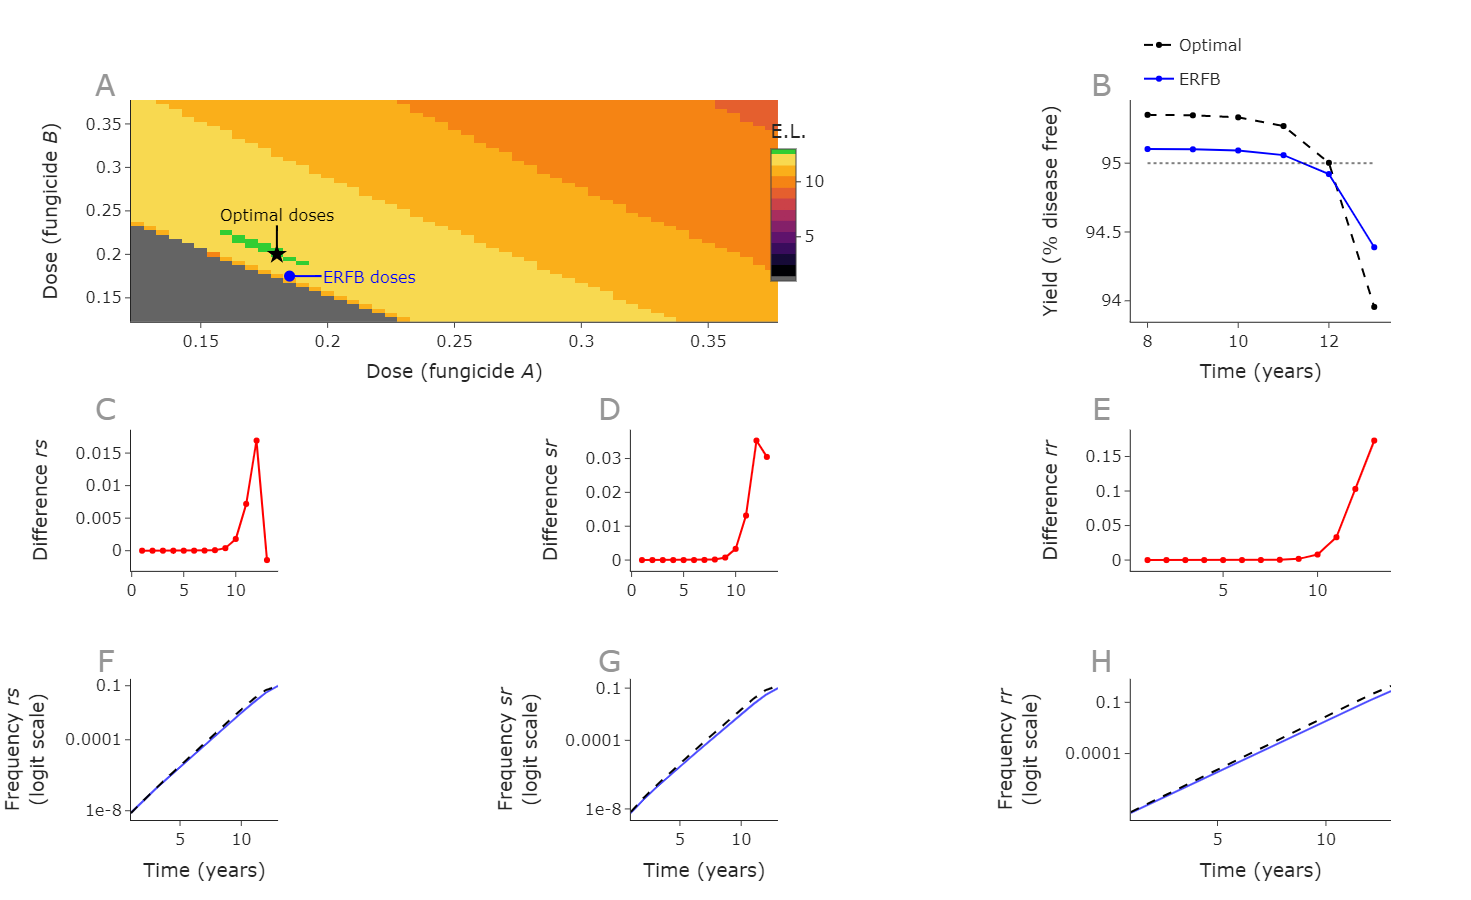

In [426]:
df_plot = df_use.loc[lambda df: df.year<14]

top1 = 0.44
bottom2 = 0.28

left2 = 0.26
right1 = 0.46

fig = make_subplots(rows=3,
                    cols=3,
                    horizontal_spacing=0.28,
                    vertical_spacing=0.15,
                    column_widths=[left2, left2, right1],
                    row_heights=[top1, bottom2, bottom2],
                    specs=[
                           [{"colspan": 2}, None, {}],
                           [{}, {}, {}],
                           [{}, {}, {}],
                    ],
                   )


# top right
start = 7
fig.add_trace(dict(x=df_plot.year.iloc[start:], y=df_plot.y_b.iloc[start:], line=dict(color='black', dash='dash'), 
                   legendgroup='b', name='Optimal'), 
                   row=1, col=3)

fig.add_trace(dict(x=df_plot.year.iloc[start:], y=df_plot.y_rfb.iloc[start:], line=dict(color='blue'), 
                   legendgroup='rfb', name='ERFB'), 
                   row=1, col=3)

xx = df_plot.year.iloc[start:]
yy = [95]*len(xx)

fig.add_trace(dict(x=xx, y=yy, line=dict(color=FADED_LINE_COLOR, dash='dot'),
              mode='lines', showlegend=False), 
              row=1, col=3)

# second bottom row
fig.add_trace(dict(x=df_plot.year, y=df_plot.rr_diff, line=dict(color='red'), 
              showlegend=False), 
              row=2, col=3)

fig.add_trace(dict(x=df_plot.year, y=df_plot.rs_diff, line=dict(color='red'), 
              showlegend=False),
              row=2, col=1)

fig.add_trace(dict(x=df_plot.year, y=df_plot.sr_diff, line=dict(color='red'),
              showlegend=False),
              row=2, col=2)

# bottom row
fig.add_trace(dict(x=df_plot.year, y=df_plot.rr_rfb_l, line=dict(color='blue'), opacity=0.7, 
              mode='lines',
              showlegend=False), 
              row=3, col=3)

fig.add_trace(dict(x=df_plot.year, y=df_plot.rs_rfb_l, line=dict(color='blue'), opacity=0.7, 
              mode='lines',
              showlegend=False),
              row=3, col=1)

fig.add_trace(dict(x=df_plot.year, y=df_plot.sr_rfb_l, line=dict(color='blue'), opacity=0.7,
              mode='lines',
              showlegend=False),
              row=3, col=2)

fig.add_trace(dict(x=df_plot.year, y=df_plot.rr_b_l, line=dict(color='black', dash='dash'), 
              mode='lines',
              showlegend=False), 
              row=3, col=3)

fig.add_trace(dict(x=df_plot.year, y=df_plot.rs_b_l, line=dict(color='black', dash='dash'), 
              mode='lines',
              showlegend=False),
              row=3, col=1)

fig.add_trace(dict(x=df_plot.year, y=df_plot.sr_b_l, line=dict(color='black', dash='dash'),
              mode='lines',
              showlegend=False),
              row=3, col=2)


# top left
FYs = np.transpose(grid_out.FY)

xheat = np.linspace(0, 1, FYs.shape[0])
yheat = np.linspace(0, 1, FYs.shape[1])

lower = 25
upper = 76

grey_map = go.Heatmap(
    x=xheat[lower:upper],
    y=yheat[lower:upper],
    z=FYs[lower:upper, lower:upper],
    colorscale=grey_colorscale_discrete(FYs),
    colorbar=my_colorbar_subplot(
        "E.L.", 
        0.50,
        0.86,
        0.25,
    )
)

fig.add_trace(grey_map, row=1, col=1)

fig.add_trace(go.Scatter(x=[dose_b1], y=[dose_b2], mode='markers',
              marker=dict(color='black', size=15, symbol="star"), showlegend=False),
              row=1, col=1)

fig.add_trace(go.Scatter(x=[dose_rfb1], y=[dose_rfb2], mode='markers',
              marker=dict(color='blue', size=11, symbol="circle"), showlegend=False),
              row=1, col=1)



# layout

fig.update_xaxes(title="Time (years)", row=3, col=1, showgrid=False, zeroline=False)
fig.update_xaxes(title="Time (years)", row=3, col=2, showgrid=False, zeroline=False)
fig.update_xaxes(title="Time (years)", row=3, col=3, showgrid=False, zeroline=False)

fig.update_xaxes(title="Time (years)", row=1, col=3, showgrid=False, zeroline=False)

fig.update_xaxes(title="Dose (fungicide <i>A</i>)", row=1, col=1, showgrid=False, zeroline=False)


fig.update_yaxes(title="Yield (% disease free)", row=1, col=3, showgrid=False, zeroline=False)

fig.update_yaxes(title="Difference <i>rr</i>", row=2, col=3, showgrid=False, zeroline=False)
fig.update_yaxes(title="Difference <i>rs</i>", row=2, col=1, showgrid=False, zeroline=False)
fig.update_yaxes(title="Difference <i>sr</i>", row=2, col=2, showgrid=False, zeroline=False)


ticktext = [1e-8, 1e-4, 1e-1]
nptt = np.array(ticktext)
tickvals = np.log10(nptt/(1-nptt))

fig.update_yaxes(title="Frequency <i>rr</i><br>(logit scale)",
                  tickvals = tickvals,
                  ticktext = ticktext,
                 row=3, col=3, showgrid=False, zeroline=False)
fig.update_yaxes(title="Frequency <i>rs</i><br>(logit scale)",
                  tickvals = tickvals,
                  ticktext = ticktext,
                 row=3, col=1, showgrid=False, zeroline=False)
fig.update_yaxes(title="Frequency <i>sr</i><br>(logit scale)",
                  tickvals = tickvals,
                  ticktext = ticktext,
                 row=3, col=2, showgrid=False, zeroline=False)


fig.update_yaxes(title="Dose (fungicide <i>B</i>)", row=1, col=1, showgrid=False, zeroline=False)


left = -0.02
middle = 0.38
right = 0.77

top_row = 1.05
middle_row = 0.6
bottom_row = 0.25

annotz = [
    get_big_text_annotation(left, top_row, 'A'),
    get_big_text_annotation(right, top_row, 'B'),
    get_big_text_annotation(left, middle_row, 'C'),
    get_big_text_annotation(middle, middle_row, 'D'),
    get_big_text_annotation(right, middle_row, 'E'),
    get_big_text_annotation(left, bottom_row, 'F'),
    get_big_text_annotation(middle, bottom_row, 'G'),
    get_big_text_annotation(right, bottom_row, 'H'),
    dict(
         text="Optimal doses", 
         x=dose_b1,
         y=dose_b2,
         xref="x1", 
         yref="y1",
         ay=-40,
         ax=0,
         arrowsize=2,
         arrowwidth=2,
         arrowhead=0,
         arrowcolor="black",
         font=dict(
                color="black",
                size=16,
         ),
         # textcolor="black",
    ),
    dict(
         text="ERFB doses", 
         x=dose_rfb1,
         y=dose_rfb2,
         xref="x1", 
         yref="y1",
         ay=0,
         ax=80,
         arrowsize=2,
         arrowwidth=2,
         arrowhead=0,
         arrowcolor="blue",
         font=dict(
            color="blue",
            size=16,
         ),
    ),
]

fig.update_layout(standard_layout(True, FULL_PAGE_WIDTH, 900))

fig.update_layout(legend=dict(x=0.8, y=1.1))

fig.update_layout(annotations=annotz)


filename='../outputs/figures/paper_figs/sub_opt_explanation.png'
print(f'saving to {filename}')
fig.write_image(filename)

fig.show()

# Parameter values:

In [427]:
fung_params

{'omega_1': 0.8124904741105804,
 'omega_2': 0.6927803763811795,
 'delta_1': 0.004001383855574,
 'delta_2': 0.0067707565353618,
 'theta_1': 2.951951169550618,
 'theta_2': 7.009988699098293}

In [428]:
primary_inoc

{'RR': 1.1657128467798915e-09,
 'RS': 5.31173814696067e-10,
 'SR': 1.3122455296914378e-10,
 'SS': 0.9999999981718888}

In [429]:
pars['sr_prop'].iloc[0]

0.6778326873508361

In [430]:
dose_rfb1

0.185

In [431]:
df_plot

,y_b,y_rfb,rr_rfb,rs_rfb,sr_rfb,rr_b,rs_b,sr_b,rr_rfb_l,rs_rfb_l,sr_rfb_l,rr_b_l,rs_b_l,sr_b_l,year,rr_diff,rs_diff,sr_diff
0,95.352479,95.103562,2.918778e-08,7.599630e-09,5.823345e-09,3.289551e-08,7.487769e-09,6.731736e-09,-7.534799,-8.119208,-8.234827,-7.482863,-8.125648,-8.171873,1,3.707724e-09,-1.118601e-10,9.083904e-10
1,95.352479,95.103562,1.187501e-07,3.729792e-08,3.373178e-08,1.420814e-07,3.806380e-08,4.168993e-08,-6.925366,-7.428315,-7.471961,-6.847463,-7.419488,-7.379969,2,2.333129e-08,7.658814e-10,7.958151e-09
2,95.352479,95.103561,4.831332e-07,1.653478e-07,1.587861e-07,6.136740e-07,1.760924e-07,2.094774e-07,-6.315933,-6.781602,-6.799187,-6.212062,-6.754259,-6.678863,3,1.305408e-07,1.074465e-08,5.069126e-08
3,95.352477,95.103560,1.965617e-06,7.017166e-07,6.922698e-07,2.650558e-06,7.844438e-07,9.733409e-07,-5.706500,-6.153838,-6.159724,-5.576662,-6.105438,-6.011735,4,6.849404e-07,8.272712e-08,2.810711e-07
4,95.352467,95.103552,7.997025e-06,2.916736e-06,2.915734e-06,1.144809e-05,3.436853e-06,4.363848e-06,-5.097068,-5.535102,-5.535251,-4.941262,-5.463838,-5.360128,5,3.451062e-06,5.201164e-07,1.448114e-06
5,95.352425,95.103522,3.253472e-05,1.199802e-05,1.207516e-05,4.944377e-05,1.494292e-05,1.921970e-05,-4.487639,-4.920885,-4.918102,-4.305867,-4.825558,-4.716245,6,1.690905e-05,2.944893e-06,7.144537e-06
6,95.352242,95.103397,1.323493e-04,4.908585e-05,4.957579e-05,2.135094e-04,6.472511e-05,8.385767e-05,-3.878221,-4.309022,-4.304709,-3.670490,-4.188899,-4.076421,7,8.116009e-05,1.563926e-05,3.428188e-05
7,95.351452,95.102888,5.381675e-04,2.001529e-04,2.025271e-04,9.213111e-04,2.796132e-04,3.637591e-04,-3.268849,-3.698551,-3.693429,-3.035193,-3.553321,-3.439028,8,3.831436e-04,7.946027e-05,1.612321e-04
8,95.348037,95.100819,2.184671e-03,8.130890e-04,8.235540e-04,3.963092e-03,1.201839e-03,1.567247e-03,-2.659664,-3.089509,-3.083950,-2.400241,-2.919631,-2.804181,9,1.778421e-03,3.887502e-04,7.436934e-04
9,95.333300,95.092400,8.808881e-03,3.269748e-03,3.313733e-03,1.682173e-02,5.070590e-03,6.623218e-03,-2.051237,-2.484063,-2.478241,-1.766762,-2.292734,-2.176045,10,8.012847e-03,1.800842e-03,3.309485e-03
